In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys, os

# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
from collections import defaultdict
from utils.io_results import load_results, group_results_by_subject
from utils.plot.plot_decomp import plot_example_subjects

# --- Load combined FCs ---
RES_DIR = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/fc"

In [3]:
vlmd_results = load_results(RES_DIR)
vlmd_subjects_dict = group_results_by_subject(vlmd_results)

[Load] Loaded 165 FC result files from /cluster/home/herminea/mental_health_project/test/results/fmri_prep/mvmd/fc


In [4]:
freq_bands = {
    #"Slow-6": (0.005, 0.01),
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}

In [5]:
#plot_example_subjects(vlmd_results, plot_hht=True, plot_psd=True, method_name="VLMD", freq_bands=freq_bands, save_figs=False)

In [6]:
vlmd_groups = { subj: entries[0]["group"] 
               for subj, entries in vlmd_subjects_dict.items() 
            }

In [ ]:
import pandas as pd
import numpy as np

# --- Load mapping file ---
atlas_df = pd.read_csv("/cluster/home/herminea/mental_health_project/workspace/atlas/roi_to_net_434.csv")

# --- Extract columns cleanly ---
atlas_df["NetworkID"] = pd.to_numeric(atlas_df["NetworkID"], errors="coerce").astype(int)
atlas_df["NetworkName"] = atlas_df["NetworkName"].astype(str)


# ROI → network mapping (numeric, 0–20)
roi_to_net = atlas_df["NetworkID"].values
n_networks = len(np.unique(roi_to_net))

net_names_21 = (
    atlas_df.groupby("NetworkID")["NetworkName"]
    .first()
    .to_list()
)


In [8]:
import numpy as np

def compute_network_marginal_spectrum(inst_amp, inst_freq, roi_to_net,
                                      net_idx, fs, fmax=0.25, nbins=200):
    """
    inst_amp, inst_freq: arrays (K, T, R)
    roi_to_net: array (R,), mapping ROIs to network IDs (0..n_networks-1)
    net_idx: which network to compute the spectrum for
    Returns:
        freqs: (nbins,)
        marginal: (nbins,) marginal Hilbert spectrum for that network
    """
    K, T, R = inst_amp.shape
    freq_bins = np.linspace(0, fmax, nbins + 1)

    # ROIs belonging to this network
    mask_roi = (roi_to_net == net_idx)
    if not np.any(mask_roi):
        return None, None

    # Average amplitude and frequency across ROIs of this network
    amp_net = inst_amp[:, :, mask_roi].mean(axis=2)   # (K, T)
    frq_net = inst_freq[:, :, mask_roi].mean(axis=2)  # (K, T)

    # Bin by frequency
    inds = np.digitize(frq_net, freq_bins) - 1
    inds = inds.clip(0, len(freq_bins) - 2)

    H = np.zeros(len(freq_bins) - 1)

    # Accumulate amplitude into frequency bins for all IMFs and time points
    for k in range(K):
        np.add.at(H, inds[k, :], amp_net[k, :])

    # Average over time (discrete approximation of integral over t)
    H /= T

    # Frequency bin centers
    freqs = 0.5 * (freq_bins[:-1] + freq_bins[1:])
    return freqs, H


In [9]:
from utils.decomp import compute_hht

fs = 1 / 0.8  # TR = 0.8 s
fmax = 0.25
nbins = 200

# For each network: group -> list of spectra (one per subject)
net_marginals = {
    net_idx: {"MDD": [], "HC": []}
    for net_idx in range(n_networks)
}

# We’ll also store freqs once (same for all subjects if params are fixed)
freqs_ref = None

for subj, entries in vlmd_subjects_dict.items():
    e = entries[0]
    imfs = e["imfs"]  # (K, T, R)
    group = vlmd_groups[subj]  # "MDD" or "HC"

    inst_amp, inst_freq = compute_hht(imfs, fs=fs, smooth_sigma=1)

    for net_idx in range(n_networks):
        freqs, H = compute_network_marginal_spectrum(
            inst_amp, inst_freq, roi_to_net, net_idx, fs=fs, fmax=fmax, nbins=nbins
        )
        if freqs is None:
            continue

        if freqs_ref is None:
            freqs_ref = freqs  # store first non-empty

        net_marginals[net_idx][group].append(H)


In [10]:
def add_freq_bands(ax, freq_bands, alpha=0.15):
    """Shade canonical fMRI frequency bands with predefined colors."""
    colors = ["#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f"]  # Slow-5..Slow-2
    for (band, (fmin, fmax)), c in zip(freq_bands.items(), colors):
        ax.axvspan(fmin, fmax, color=c, alpha=alpha, zorder=0)



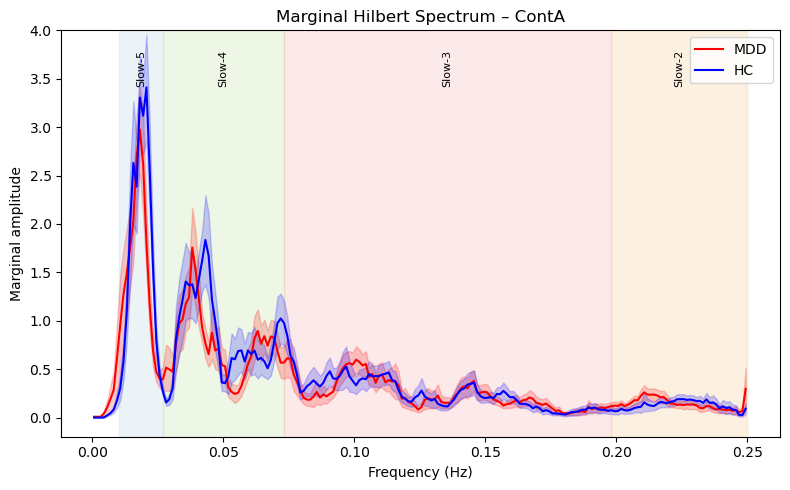

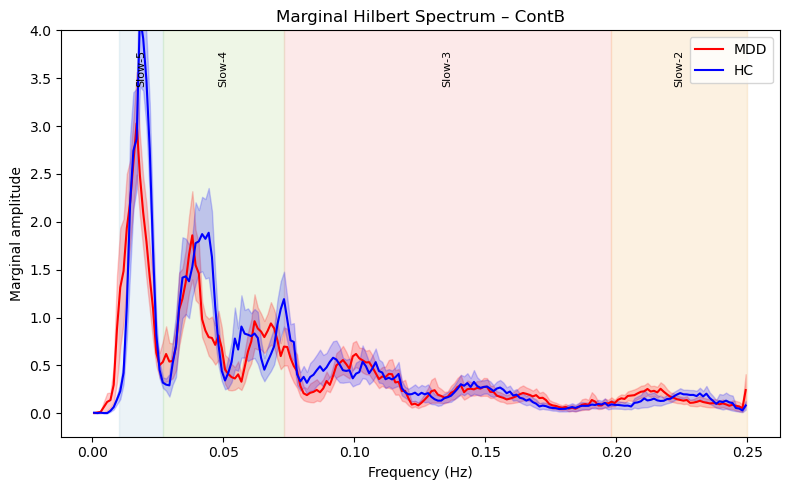

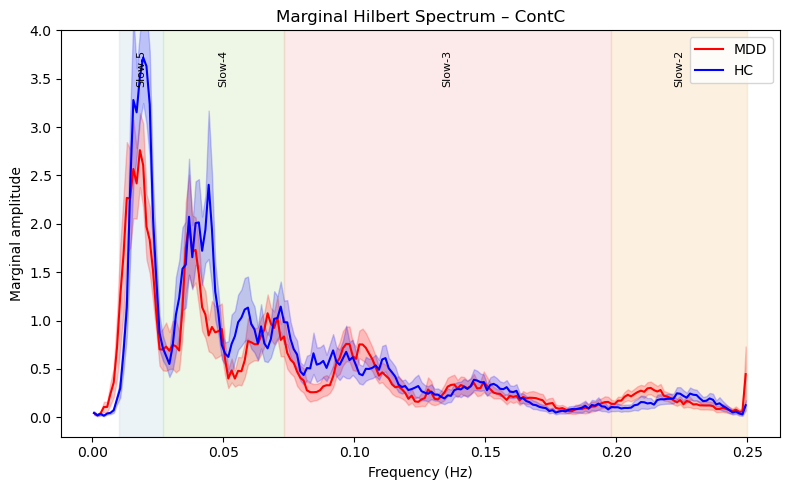

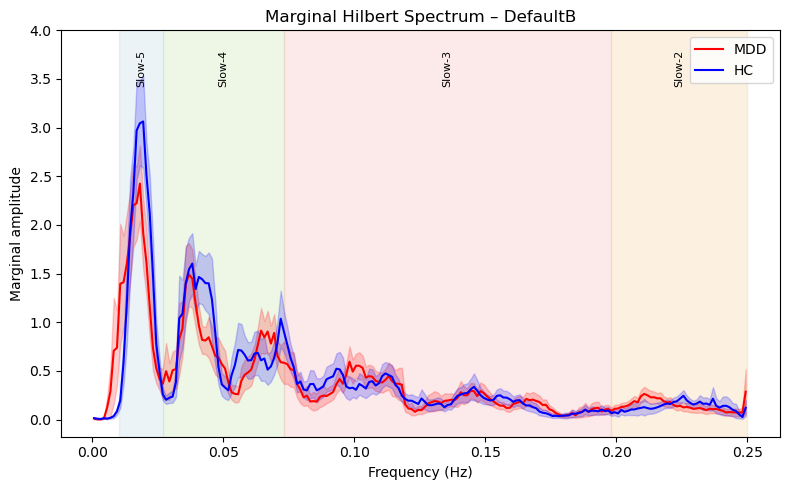

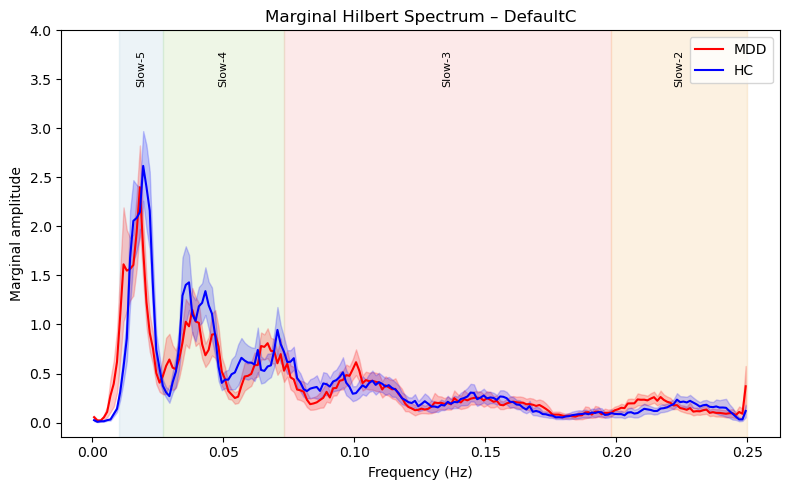

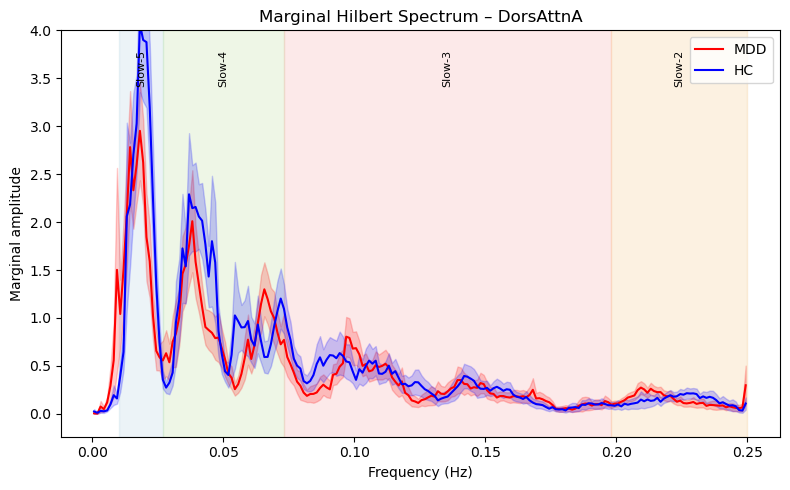

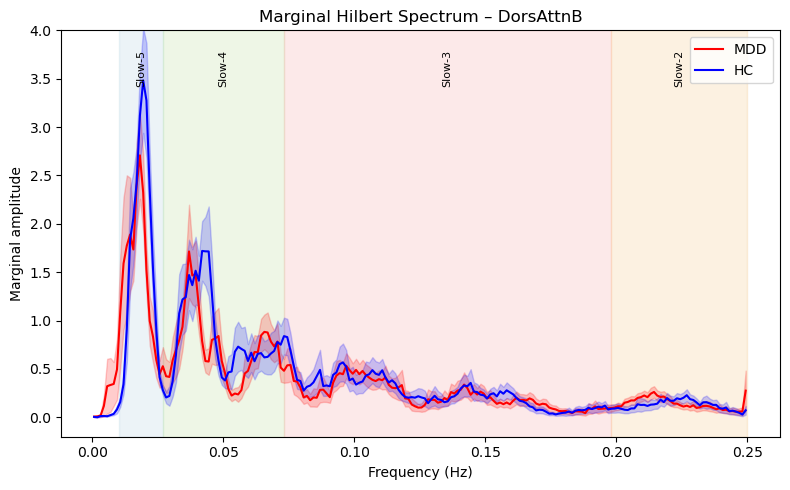

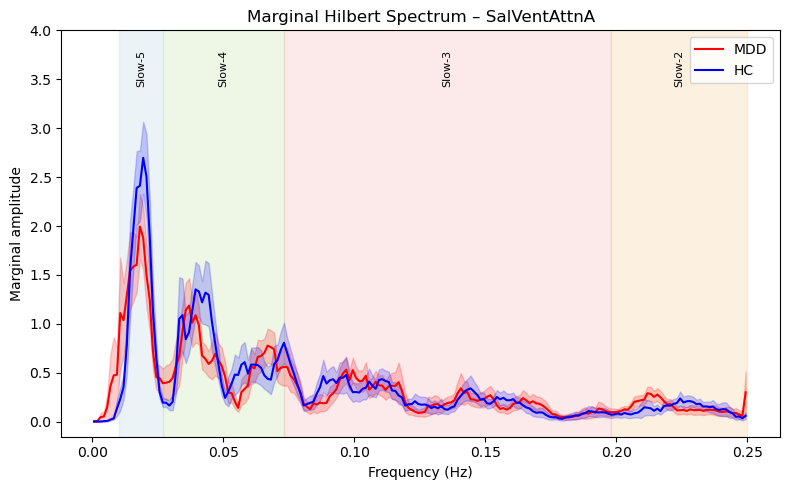

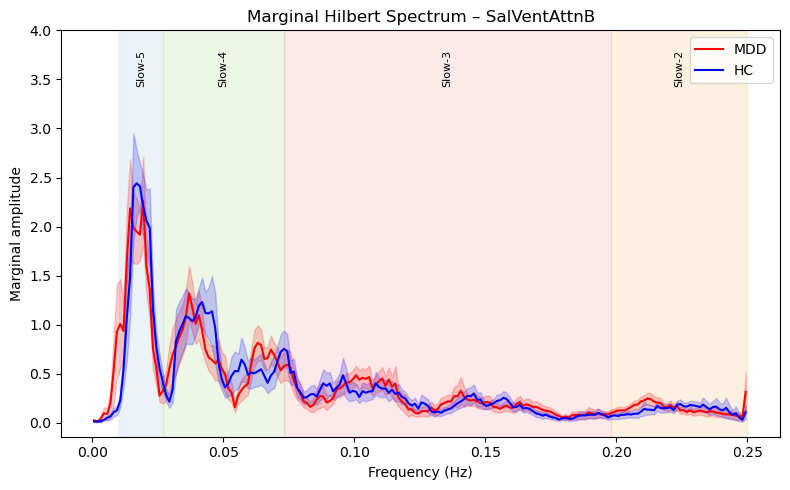

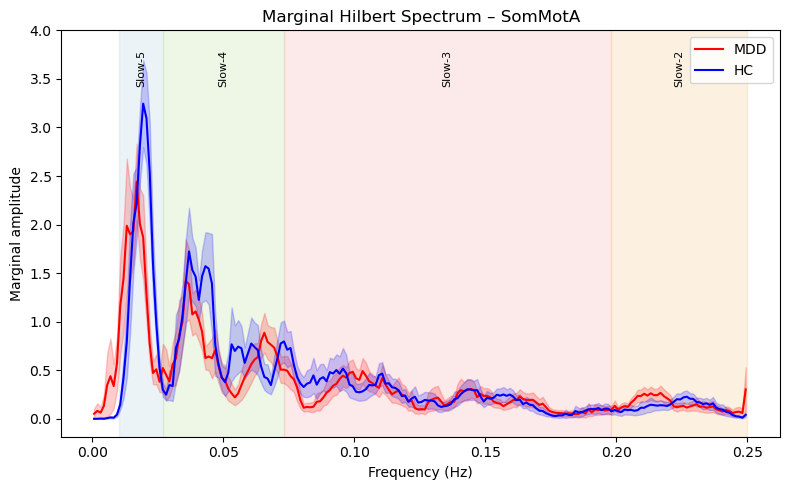

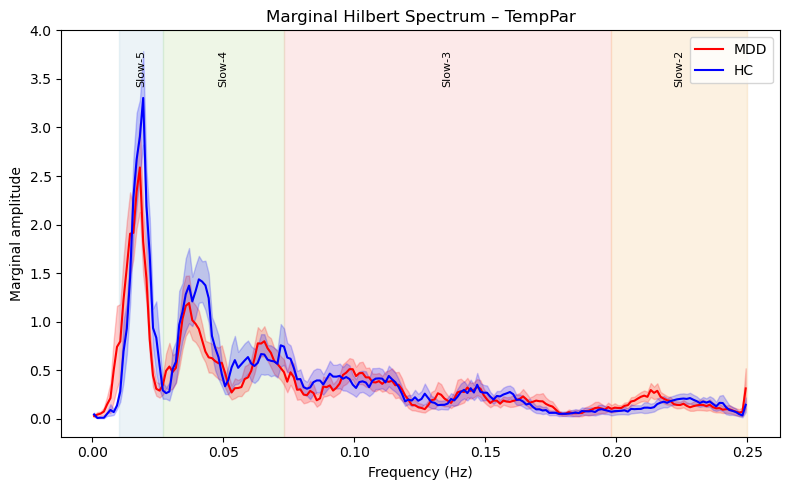

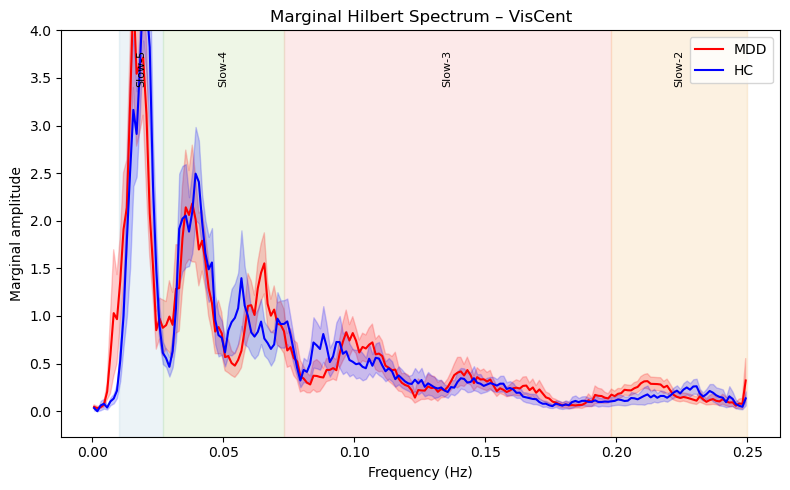

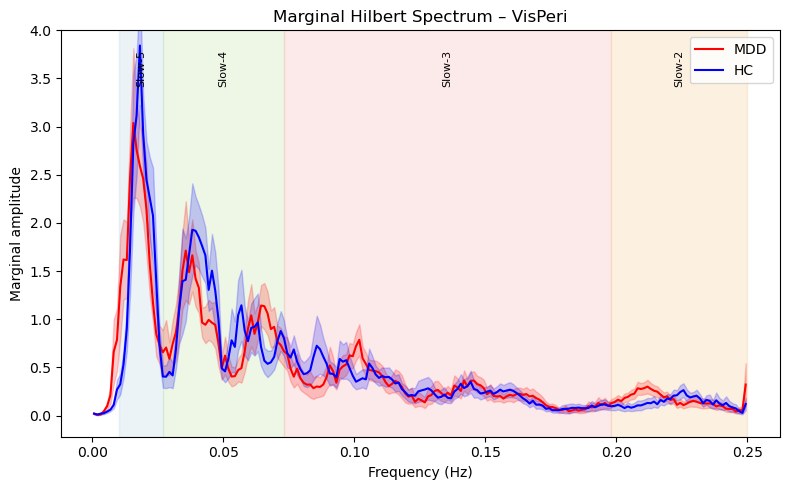

In [11]:

import matplotlib.pyplot as plt
import numpy as np

#net_list = ["LimbicA", "LimbicB", "MTL", "Thalamus",  "Cerebellum", "Striatum", "SomMotB", "DefaultA"]
net_list = ["ContA", "ContB", "ContC", "DefaultB", "DefaultC", "DorsAttnA", "DorsAttnB", 
            "SalVentAttnA", "SalVentAttnB", "SomMotA", "TempPar", "VisCent", "VisPeri"]

for net_name in net_list:
    net_idx = net_names_21.index(net_name)

    mdd_arr = np.vstack(net_marginals[net_idx]["MDD"])  # (n_MDD, nbins)
    hc_arr  = np.vstack(net_marginals[net_idx]["HC"])   # (n_HC, nbins)

    mdd_mean = mdd_arr.mean(axis=0)
    hc_mean  = hc_arr.mean(axis=0)

    mdd_se = mdd_arr.std(axis=0) / np.sqrt(mdd_arr.shape[0])
    hc_se  = hc_arr.std(axis=0) / np.sqrt(hc_arr.shape[0])

    # ---- Create figure FIRST ----
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot group mean ± SE
    ax.plot(freqs_ref, mdd_mean, label="MDD", color="red")
    ax.fill_between(freqs_ref, mdd_mean - mdd_se, mdd_mean + mdd_se,
                    color="red", alpha=0.2)

    ax.plot(freqs_ref, hc_mean, label="HC", color="blue")
    ax.fill_between(freqs_ref, hc_mean - hc_se, hc_mean + hc_se,
                    color="blue", alpha=0.2)

    # y-limits based on data
    ymin, ymax = ax.get_ylim()

    # ---- Colored frequency bands ----
    add_freq_bands(ax, freq_bands, alpha=0.20)
    for band, (fmin, fmax) in freq_bands.items():
        ax.text((fmin + fmax)/2, 0.95*4, band, ha="center", va="top", fontsize=8, rotation=90)

    # Optional: shade whole band lightly (0.01–0.25 Hz)
    ax.axvspan(0.01, 0.25, color="lightgrey", alpha=0.03, zorder=0)

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Marginal amplitude")
    ax.set_ylim(ymin, 4)  # or (ymin, 4) if you really want to fix max
    ax.set_title(f"Marginal Hilbert Spectrum – {net_name}")
    ax.legend()
    fig.tight_layout()
    plt.show()


In [ ]:
# --- Load combined FCs ---
COMB_RES_DIR = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/vlmd/combined_fc"
def load_fc_data(res_dir):
    results = load_results(res_dir)
    subjects_combined = group_results_by_subject(results)

    fcs_by_imf = defaultdict(dict)
    groups = {}
    freqs_by_imf = defaultdict(list)

    for subj, entries in subjects_combined.items():
        entry = entries[0]
        groups[subj] = entry["group"]
        fcs_by_imf["whole"][subj] = entry["fc_whole"]
        for i, fc in enumerate(entry["fc_modes"], start=1):
            fcs_by_imf[i][subj] = fc
            freqs_by_imf[i].append(entry["freqs"][i-1])

    return subjects_combined, fcs_by_imf, groups, freqs_by_imf

subjects_combined, fcs_by_imf, groups, freqs_by_imf = load_fc_data(COMB_RES_DIR)

[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/test/results/fmri_prep/vlmd/combined_fc


In [13]:
def bin_fcs_by_freq(subjects_combined, freq_bands):
    binned = {band: defaultdict(list) for band in freq_bands}
    
    for subj, entries in subjects_combined.items():
        e = entries[0]
        # Assign each IMF FC to its corresponding frequency band
        for f, fc in zip(e["freqs"], e["fc_modes"]):
            for band, (fmin, fmax) in freq_bands.items():
                if fmin <= f < fmax:
                    binned[band][subj].append(fc)
                    


    # Average FCs per subject for each band
    binned_mean = {
        band: {s: np.nanmean(fcs, axis=0) for s, fcs in subj_dict.items()}
        for band, subj_dict in binned.items()
    }

    return binned_mean

fcs_by_band = bin_fcs_by_freq(subjects_combined, freq_bands)
fcs_by_band["Whole"] = {s: fcs_by_imf["whole"][s] for s in fcs_by_imf["whole"]}

from collections import OrderedDict

order = ["Whole", "Slow-6", "Slow-5", "Slow-4", "Slow-3", "Slow-2"]
fcs_by_band = OrderedDict((k, fcs_by_band[k]) for k in order if k in fcs_by_band)

def aggregate_to_network_fc(fc, roi_to_net, n_networks):
    net_fc = np.zeros((n_networks, n_networks))
    for i in range(n_networks):
        idx_i = np.where(roi_to_net == i)[0]
        for j in range(n_networks):
            idx_j = np.where(roi_to_net == j)[0]
            vals = fc[np.ix_(idx_i, idx_j)]
            net_fc[i, j] = np.nanmean(vals)
    net_fc = (net_fc + net_fc.T) / 2
    #np.fill_diagonal(net_fc, 0)
    return net_fc

binned_netfcs = {
    band: {s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
           for s, fc in subj_dict.items()}
    for band, subj_dict in fcs_by_band.items()
}

whole_netfcs = {
    s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
    for s, fc in fcs_by_imf["whole"].items()
}


z_binned_netfcs = {}

for band, subj_fcs in binned_netfcs.items():
    z_binned_netfcs[band] = {}
    for s, fc in subj_fcs.items():
        # Assume fc is Pearson r. Clip to avoid infs.
        fc_clipped = np.clip(fc, -0.999999, 0.999999)
        z_binned_netfcs[band][s] = np.arctanh(fc_clipped)  # Fisher z

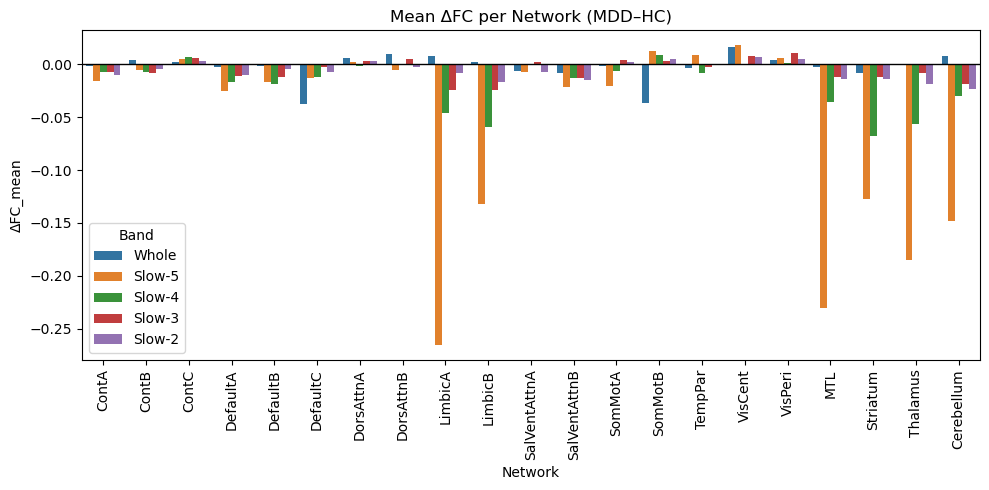

In [14]:
summary = []

for band, subj_fcs in z_binned_netfcs.items():
    subs = list(subj_fcs.keys())
    group_labels = [groups[s] for s in subs]
    mdd = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "MDD"])
    hc  = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "HC"])
    
    diff_mat = np.nanmean(mdd, axis=0) - np.nanmean(hc, axis=0)

    # Exclude self-connections
    diff_mat_no_diag = diff_mat.copy()
    np.fill_diagonal(diff_mat_no_diag, np.nan)

    mean_dfc = np.nanmean(diff_mat_no_diag, axis=1)
    
    df_band = pd.DataFrame({
        "Network": net_names_21,
        "ΔFC_mean": mean_dfc,
        "Band": band
    })
    summary.append(df_band)

summary_df = pd.concat(summary)

# plot per band
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x="Network", y="ΔFC_mean", hue="Band")
plt.axhline(0, color='k', lw=1)
plt.xticks(rotation=90)
plt.title("Mean ΔFC per Network (MDD–HC)")
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np

spec_summary = []

# choose bands you want to relate to FC
bands_of_interest = ["Slow-5", "Slow-4"]  # add "Slow-3" etc if you like

for band in bands_of_interest:
    fmin, fmax = freq_bands[band]
    band_mask = (freqs_ref >= fmin) & (freqs_ref <= fmax)
    
    band_diffs = []
    for net_name in net_names_21:
        net_idx = net_names_21.index(net_name)

        mdd_arr = np.vstack(net_marginals[net_idx]["MDD"])
        hc_arr  = np.vstack(net_marginals[net_idx]["HC"])

        mdd_mean = mdd_arr.mean(axis=0)
        hc_mean  = hc_arr.mean(axis=0)

        # HC – MDD amplitude difference in this band
        amp_diff = hc_mean[band_mask].mean() - mdd_mean[band_mask].mean()
        band_diffs.append(amp_diff)
    
    df_band = pd.DataFrame({
        "Network": net_names_21,
        "Band": band,
        "AmpDiff_HC_minus_MDD": band_diffs
    })
    spec_summary.append(df_band)

spec_df = pd.concat(spec_summary, ignore_index=True)

# keep the same bands as in the spectral summary
dfc_sub = summary_df[summary_df["Band"].isin(bands_of_interest)]

merged = pd.merge(
    dfc_sub,
    spec_df,
    on=["Network", "Band"],
    how="inner"
)


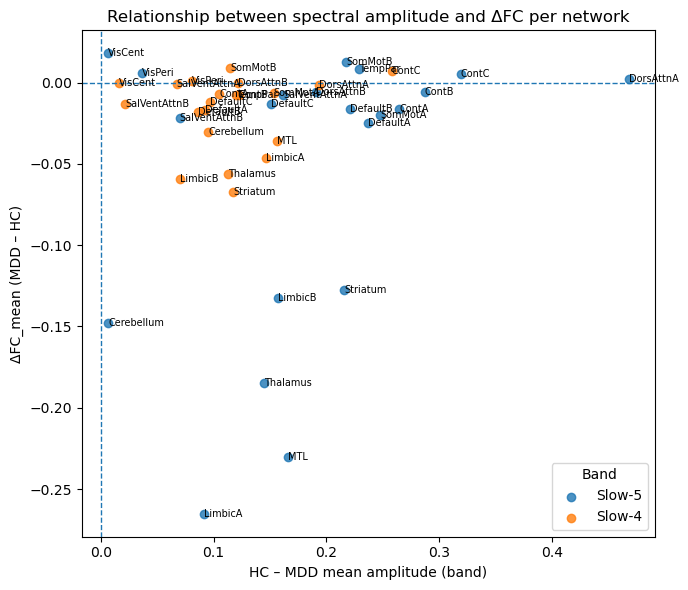

In [16]:
import matplotlib.pyplot as plt

bands_to_plot = ["Slow-5", "Slow-4"]  # same as above

fig, ax = plt.subplots(figsize=(7, 6))

for band in bands_to_plot:
    sub = merged[merged["Band"] == band]
    
    ax.scatter(
        sub["AmpDiff_HC_minus_MDD"],
        sub["ΔFC_mean"],
        label=band,
        alpha=0.8
    )
    
    # annotate each point with the network name
    for _, row in sub.iterrows():
        ax.text(
            row["AmpDiff_HC_minus_MDD"],
            row["ΔFC_mean"],
            row["Network"],
            fontsize=7,
            ha="left",
            va="center"
        )

ax.axhline(0, linestyle="--", linewidth=1)
ax.axvline(0, linestyle="--", linewidth=1)

ax.set_xlabel("HC – MDD mean amplitude (band)")
ax.set_ylabel("ΔFC_mean (MDD – HC)")
ax.set_title("Relationship between spectral amplitude and ΔFC per network")
ax.legend(title="Band")
fig.tight_layout()
plt.show()


In [17]:
for band in bands_to_plot:
    sub = merged[merged["Band"] == band]
    r = np.corrcoef(sub["AmpDiff_HC_minus_MDD"], sub["ΔFC_mean"])[0, 1]
    print(f"{band}: r = {r:.2f}")


Slow-5: r = 0.31
Slow-4: r = 0.09
